In [7]:
import numpy as np
from scipy.stats import rankdata
import pandas as pd
import sys
from pathlib import Path
import os

# NOT USED: ASSIGNS TIES THE SAME RANK
# def rank_column_with_ties(col):
#     """Custom function for ranking that labels same values with the same rank"""
#     sorted_indices = np.argsort(col)
#     ranks = np.zeros_like(col, dtype=int)
#     rank = 1
    
#     # Assign ranks based on sorted order and handle ties
#     for i in range(len(col)):
#         if i > 0 and col[sorted_indices[i]] != col[sorted_indices[i - 1]]:
#             rank = i + 1
#         ranks[sorted_indices[i]] = rank
#     return ranks

def rank_column_with_unique_ties(col):
    """Custom function for ranking that assigns different ranks to tied values"""
    sorted_indices = np.argsort(col)
    ranks = np.zeros_like(col, dtype=int)
    
    # Assign ranks based on sorted order without considering ties
    for i in range(len(col)):
        ranks[sorted_indices[i]] = i + 1  # Assign ranks sequentially
    return ranks


def quantile_normalize(values):
    """Quantile normalizes 2D array"""
    sorted_values = np.sort(values, axis=1)
    ranked = np.apply_along_axis(rank_column_with_unique_ties, 1, values)

    # Calculate the mean value at each rank
    quantiles = np.mean(sorted_values, axis=0)

    # Vectorize the replacement function for efficiency
    replacement_map = {i+1: quantiles[i] for i in range(len(quantiles))}
    vectorized_replace = np.vectorize(lambda x: replacement_map.get(x, x))

    # Replace ranks with corresponding mean values
    normalized_values = vectorized_replace(ranked)
    return normalized_values

def load_bed_file(input_file, i):
    df = pd.read_csv(input_file, sep='\t', header=None)
    if df.shape[1] < i:
        raise ValueError(f'The input file must have at least {i} columns.')
    return df

def save_bed_file(df, output_file):
    df.to_csv(output_file, sep='\t', header=False, index=False)

def main(input_files, output_files, i=5):
    """Saves quantile normalized data to output_files"""
    dfs = [load_bed_file(file, i) for file in input_files]
    
    # 2D array - each df occupies a row
    all_values = np.vstack([df[4].values for df in dfs])
    
    # Quantile normalize the ith column
    all_values_qn = quantile_normalize(all_values)
    
    # Return the normalized values back into individual dfs
    index = 0
    for i, df in enumerate(dfs):
        size = df.shape[0]
        df[4] = all_values_qn[i]
        save_bed_file(df, output_files[i])

def new_path_dir(file_paths):
    """Creates path name for outfiles"""
    updated_paths = []
    for file_path in file_paths:
        path_obj = Path(file_path)

        parent_dir = path_obj.parent
        
        new_dir = Path(*parent_dir.parts, 'quantile_norm')
        updated_path = new_dir / path_obj.name
        
        new_dir.mkdir(parents=True, exist_ok=True)
        
        updated_paths.append(str(updated_path))
    
    return updated_paths
    
if __name__ == "__main__":
    infiles = sys.argv[1:]
    # print('Usage:Follow python command with input files separated by a space')
    outfiles = new_path_dir(infiles)
    
    main(infiles, outfiles)



/home/azstephe/regression_liver/data/log_same_size
/home/azstephe/regression_liver/data/log_same_size/quantile_norm/cow_liver_pos_ALL_chromName.bed


In [3]:
import numpy as np

def rank_column_with_unique_ties(col):
    """Custom function for ranking that assigns different ranks even to tied values"""
    sorted_indices = np.argsort(col)
    ranks = np.zeros_like(col, dtype=int)
    
    # Assign ranks based on sorted order without considering ties
    for i in range(len(col)):
        ranks[sorted_indices[i]] = i + 1  # Assign ranks sequentially
    return ranks

test_col = np.array([50, 20, 20, 40, 20])

# Expected result: No ties, ranks are unique and sequential
# After sorting: [20, 20, 30, 40, 50]
# Expected ranks: [5, 1, 2, 4, 3]
expected_ranks = [5, 1, 2, 4, 3]

# Run the ranking function
ranks = rank_column_with_unique_ties(test_col)

# Output the results
print("Input column:", test_col)
print("Assigned ranks:", ranks)
print("Expected ranks:", expected_ranks)
print("Test passed:", np.array_equal(ranks, expected_ranks))

Input column: [50 20 20 40 20]
Assigned ranks: [5 1 2 4 3]
Expected ranks: [5, 1, 2, 4, 3]
Test passed: True


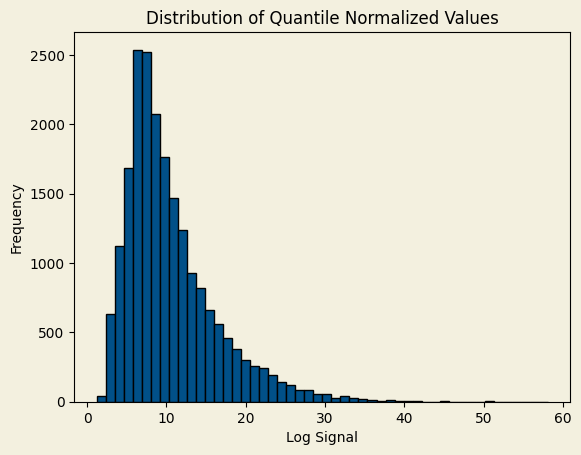

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import os

def plot_histogram_from_bed(file_path):
    # Load the BED file, assuming it's tab-separated and without a header
    df = pd.read_csv(file_path, sep='\t', header=None)

    # Ensure the file has at least 5 columns
    if df.shape[1] < 5:
        raise ValueError("The BED file must have at least 5 columns.")

    # Extract the 5th column (index 4 in pandas, since it starts from 0)
    column_5 = df[6]

    # Plot the histogram
    plt.hist(column_5, bins=50, color='#015088', edgecolor='black')
    plt.gcf().set_facecolor('#f3f0dfff')
    plt.gca().set_facecolor('#f3f0dfff')
    #plt.xlim(0.5, 4)
    tit = ('/').join(file_path.split('/')[-2:])
    plt.title(f'Distribution of Quantile Normalized Values')
    plt.xlabel('Log Signal')
    plt.ylabel('Frequency')
    
    # Show the plot
    plt.show()

# Example usage
file_path = '/home/azstephe/regression_liver/data/raw/pig_liver_pos_ALL.narrowPeak'  # Replace with your BED file path
plot_histogram_from_bed(file_path)


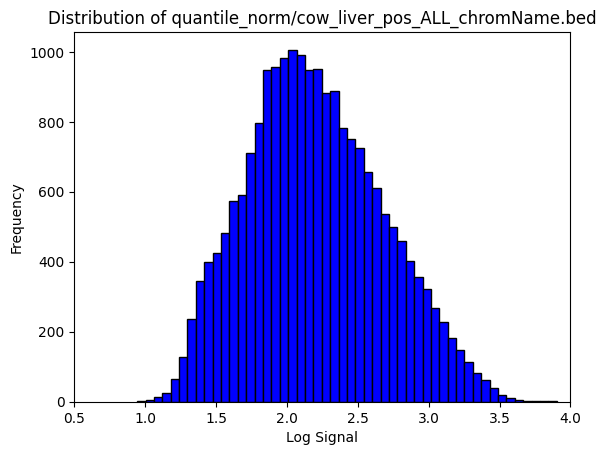

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Load the BED file into a pandas DataFrame
def plot_histogram_from_bed(file_path):
    # Load the BED file, assuming it's tab-separated and without a header
    df = pd.read_csv(file_path, sep='\t', header=None)

    # Ensure the file has at least 5 columns
    if df.shape[1] < 5:
        raise ValueError("The BED file must have at least 5 columns.")

    # Extract the 5th column (index 4 in pandas, since it starts from 0)
    column_5 = df[4]

    # Plot the histogram
    plt.hist(column_5, bins=50, color='blue', edgecolor='black')
    plt.xlim(0.5, 4)
    tit = ('/').join(file_path.split('/')[-2:])
    plt.title(f'Distribution of {tit}')
    plt.xlabel('Log Signal')
    plt.ylabel('Frequency')
    
    # Show the plot
    plt.show()

# Example usage
file_path = '/home/azstephe/regression_liver/data/quantile_norm/cow_liver_pos_ALL_chromName.bed'  # Replace with your BED file path
plot_histogram_from_bed(file_path)

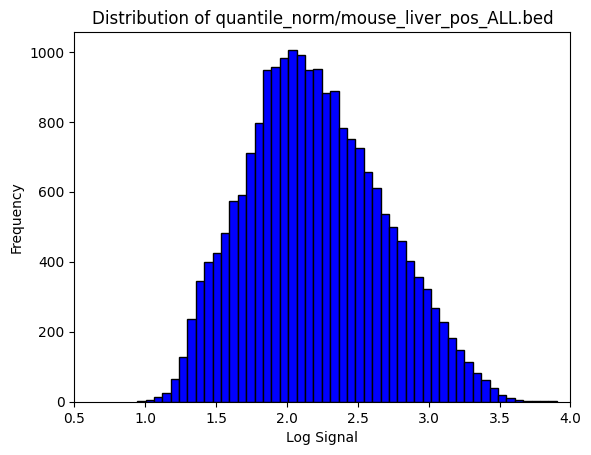

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Load the BED file into a pandas DataFrame
def plot_histogram_from_bed(file_path):
    # Load the BED file, assuming it's tab-separated and without a header
    df = pd.read_csv(file_path, sep='\t', header=None)

    # Ensure the file has at least 5 columns
    if df.shape[1] < 5:
        raise ValueError("The BED file must have at least 5 columns.")

    # Extract the 5th column (index 4 in pandas, since it starts from 0)
    column_5 = df[4]

    # Plot the histogram
    plt.hist(column_5, bins=50, color='blue', edgecolor='black')
    plt.xlim(0.5, 4)
    tit = ('/').join(file_path.split('/')[-2:])
    plt.title(f'Distribution of {tit}')
    plt.xlabel('Log Signal')
    plt.ylabel('Frequency')
    
    # Show the plot
    plt.show()

# Example usage
file_path = '/home/azstephe/regression_liver/data/quantile_norm/mouse_liver_pos_ALL.bed'  # Replace with your BED file path
plot_histogram_from_bed(file_path)

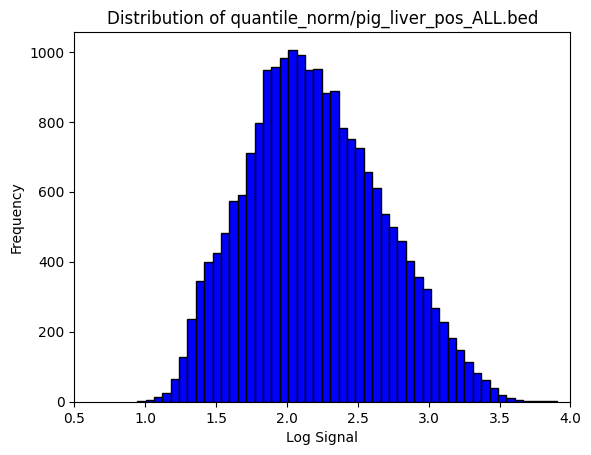

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Load the BED file into a pandas DataFrame
def plot_histogram_from_bed(file_path):
    # Load the BED file, assuming it's tab-separated and without a header
    df = pd.read_csv(file_path, sep='\t', header=None)

    # Ensure the file has at least 5 columns
    if df.shape[1] < 5:
        raise ValueError("The BED file must have at least 5 columns.")

    # Extract the 5th column (index 4 in pandas, since it starts from 0)
    column_5 = df[4]

    # Plot the histogram
    plt.hist(column_5, bins=50, color='blue', edgecolor='black')
    plt.xlim(0.5, 4)
    tit = ('/').join(file_path.split('/')[-2:])
    plt.title(f'Distribution of {tit}')
    plt.xlabel('Log Signal')
    plt.ylabel('Frequency')
    
    # Show the plot
    plt.show()

# Example usage
file_path = '/home/azstephe/regression_liver/data/quantile_norm/pig_liver_pos_ALL.bed'  # Replace with your BED file path
plot_histogram_from_bed(file_path)

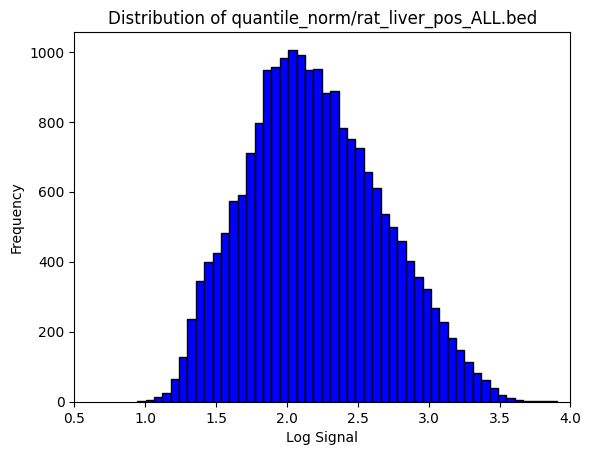

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Load the BED file into a pandas DataFrame
def plot_histogram_from_bed(file_path):
    # Load the BED file, assuming it's tab-separated and without a header
    df = pd.read_csv(file_path, sep='\t', header=None)

    # Ensure the file has at least 5 columns
    if df.shape[1] < 5:
        raise ValueError("The BED file must have at least 5 columns.")

    # Extract the 5th column (index 4 in pandas, since it starts from 0)
    column_5 = df[4]

    # Plot the histogram
    plt.hist(column_5, bins=50, color='blue', edgecolor='black')
    plt.xlim(0.5, 4)
    tit = ('/').join(file_path.split('/')[-2:])
    plt.title(f'Distribution of {tit}')
    plt.xlabel('Log Signal')
    plt.ylabel('Frequency')
    
    # Show the plot
    plt.show()

# Example usage
file_path = '/home/azstephe/regression_liver/data/quantile_norm/rat_liver_pos_ALL.bed'  # Replace with your BED file path
plot_histogram_from_bed(file_path)

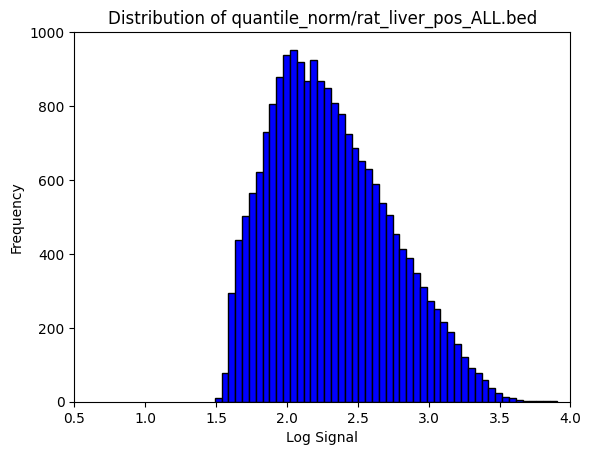

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Load the BED file into a pandas DataFrame
def plot_histogram_from_bed(file_path):
    # Load the BED file, assuming it's tab-separated and without a header
    df = pd.read_csv(file_path, sep='\t', header=None)

    # Ensure the file has at least 5 columns
    if df.shape[1] < 5:
        raise ValueError("The BED file must have at least 5 columns.")

    # Extract the 5th column (index 4 in pandas, since it starts from 0)
    column_5 = df[4]

    # Plot the histogram
    plt.hist(column_5, bins=50, color='blue', edgecolor='black')
    plt.xlim(0.5, 4)
    tit = ('/').join(file_path.split('/')[-2:])
    plt.title(f'Distribution of {tit}')
    plt.xlabel('Log Signal')
    plt.ylabel('Frequency')
    
    # Show the plot
    plt.show()

# Example usage
file_path = '/home/azstephe/regression_liver/data/sorted_log_20615/quantile_norm/rat_liver_pos_ALL.bed'  # Replace with your BED file path
plot_histogram_from_bed(file_path)

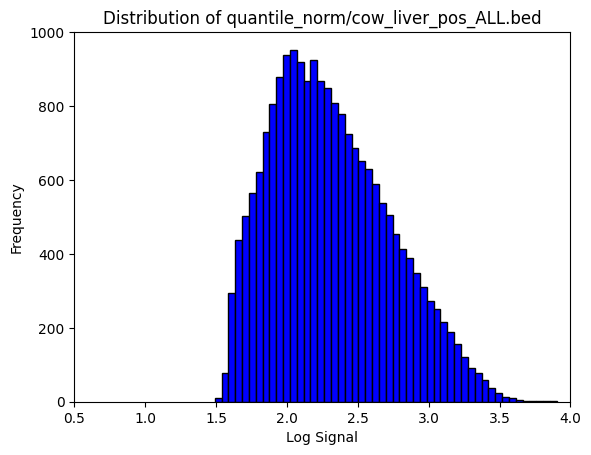

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Load the BED file into a pandas DataFrame
def plot_histogram_from_bed(file_path):
    # Load the BED file, assuming it's tab-separated and without a header
    df = pd.read_csv(file_path, sep='\t', header=None)

    # Ensure the file has at least 5 columns
    if df.shape[1] < 5:
        raise ValueError("The BED file must have at least 5 columns.")

    # Extract the 5th column (index 4 in pandas, since it starts from 0)
    column_5 = df[4]

    # Plot the histogram
    plt.hist(column_5, bins=50, color='blue', edgecolor='black')
    plt.xlim(0.5, 4)
    tit = ('/').join(file_path.split('/')[-2:])
    plt.title(f'Distribution of {tit}')
    plt.xlabel('Log Signal')
    plt.ylabel('Frequency')
    
    # Show the plot
    plt.show()

# Example usage
file_path = '/home/azstephe/regression_liver/data/sorted_log_20615/quantile_norm/cow_liver_pos_ALL.bed'  # Replace with your BED file path
plot_histogram_from_bed(file_path)

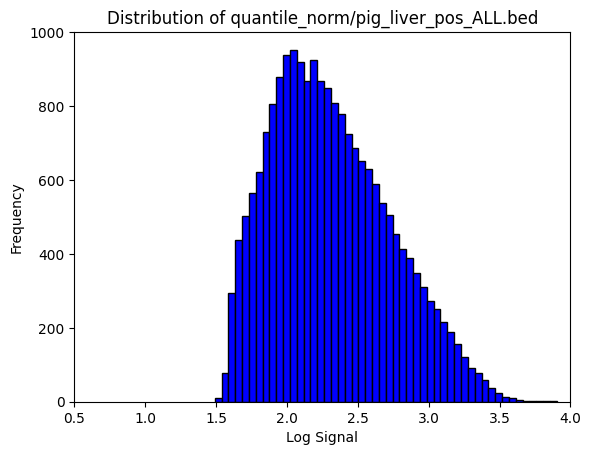

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Load the BED file into a pandas DataFrame
def plot_histogram_from_bed(file_path):
    # Load the BED file, assuming it's tab-separated and without a header
    df = pd.read_csv(file_path, sep='\t', header=None)

    # Ensure the file has at least 5 columns
    if df.shape[1] < 5:
        raise ValueError("The BED file must have at least 5 columns.")

    # Extract the 5th column (index 4 in pandas, since it starts from 0)
    column_5 = df[4]

    # Plot the histogram
    plt.hist(column_5, bins=50, color='blue', edgecolor='black')
    plt.xlim(0.5, 4)
    tit = ('/').join(file_path.split('/')[-2:])
    plt.title(f'Distribution of {tit}')
    plt.xlabel('Log Signal')
    plt.ylabel('Frequency')
    
    # Show the plot
    plt.show()

# Example usage
file_path = '/home/azstephe/regression_liver/data/sorted_log_20615/quantile_norm/pig_liver_pos_ALL.bed'  # Replace with your BED file path
plot_histogram_from_bed(file_path)

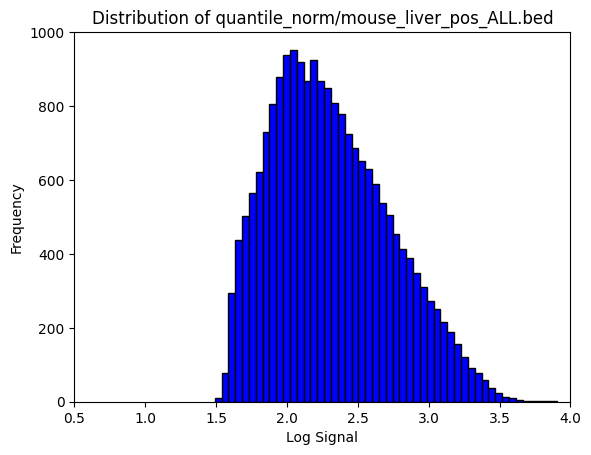

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Load the BED file into a pandas DataFrame
def plot_histogram_from_bed(file_path):
    # Load the BED file, assuming it's tab-separated and without a header
    df = pd.read_csv(file_path, sep='\t', header=None)

    # Ensure the file has at least 5 columns
    if df.shape[1] < 5:
        raise ValueError("The BED file must have at least 5 columns.")

    # Extract the 5th column (index 4 in pandas, since it starts from 0)
    column_5 = df[4]

    # Plot the histogram
    plt.hist(column_5, bins=50, color='blue', edgecolor='black')
    plt.xlim(0.5, 4)
    tit = ('/').join(file_path.split('/')[-2:])
    plt.title(f'Distribution of {tit}')
    plt.xlabel('Log Signal')
    plt.ylabel('Frequency')
    
    # Show the plot
    plt.show()

# Example usage
file_path = '/home/azstephe/regression_liver/data/sorted_log_20615/quantile_norm/mouse_liver_pos_ALL.bed'  # Replace with your BED file path
plot_histogram_from_bed(file_path)

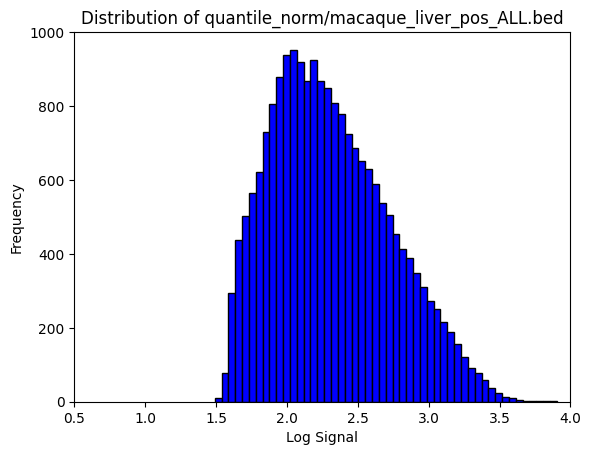

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Load the BED file into a pandas DataFrame
def plot_histogram_from_bed(file_path):
    # Load the BED file, assuming it's tab-separated and without a header
    df = pd.read_csv(file_path, sep='\t', header=None)

    # Ensure the file has at least 5 columns
    if df.shape[1] < 5:
        raise ValueError("The BED file must have at least 5 columns.")

    # Extract the 5th column (index 4 in pandas, since it starts from 0)
    column_5 = df[4]

    # Plot the histogram
    plt.hist(column_5, bins=50, color='blue', edgecolor='black')
    plt.xlim(0.5, 4)
    tit = ('/').join(file_path.split('/')[-2:])
    plt.title(f'Distribution of {tit}')
    plt.xlabel('Log Signal')
    plt.ylabel('Frequency')
    
    # Show the plot
    plt.show()

# Example usage
file_path = '/home/azstephe/regression_liver/data/sorted_log_20615/quantile_norm/macaque_liver_pos_ALL.bed'  # Replace with your BED file path
plot_histogram_from_bed(file_path)

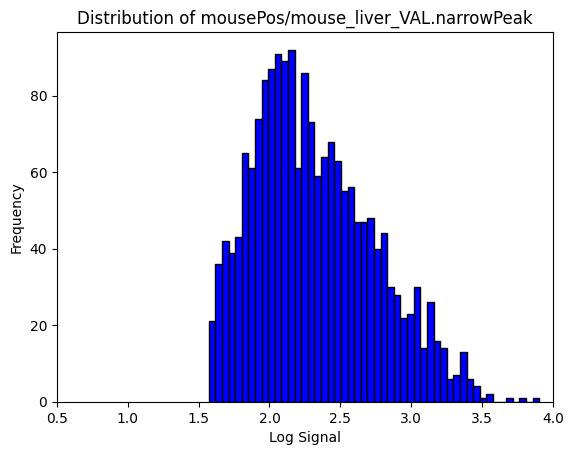

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Load the BED file into a pandas DataFrame
def plot_histogram_from_bed(file_path):
    # Load the BED file, assuming it's tab-separated and without a header
    df = pd.read_csv(file_path, sep='\t', header=None)

    # Ensure the file has at least 5 columns
    if df.shape[1] < 5:
        raise ValueError("The BED file must have at least 5 columns.")

    # Extract the 5th column (index 4 in pandas, since it starts from 0)
    column_5 = df[4]

    # Plot the histogram
    plt.hist(column_5, bins=50, color='blue', edgecolor='black')
    plt.xlim(0.5, 4)
    tit = ('/').join(file_path.split('/')[-2:])
    plt.title(f'Distribution of {tit}')
    plt.xlabel('Log Signal')
    plt.ylabel('Frequency')
    
    # Show the plot
    plt.show()

# Example usage
file_path = '/home/azstephe/regression_liver/data/sorted_log_20615/splits/mousePos/mouse_liver_VAL.narrowPeak'  # Replace with your BED file path
plot_histogram_from_bed(file_path)

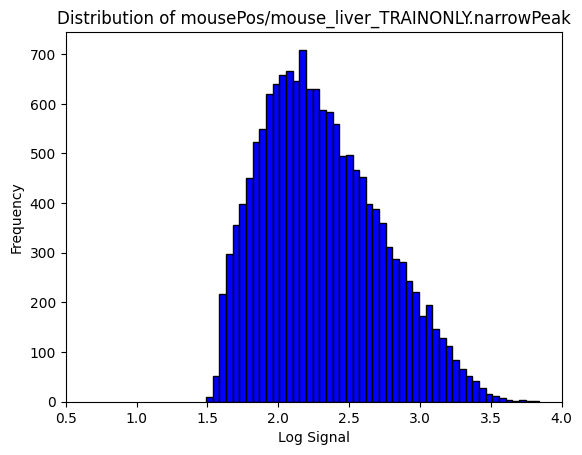

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Load the BED file into a pandas DataFrame
def plot_histogram_from_bed(file_path):
    # Load the BED file, assuming it's tab-separated and without a header
    df = pd.read_csv(file_path, sep='\t', header=None)

    # Ensure the file has at least 5 columns
    if df.shape[1] < 5:
        raise ValueError("The BED file must have at least 5 columns.")

    # Extract the 5th column (index 4 in pandas, since it starts from 0)
    column_5 = df[4]

    # Plot the histogram
    plt.hist(column_5, bins=50, color='blue', edgecolor='black')
    plt.xlim(0.5, 4)
    tit = ('/').join(file_path.split('/')[-2:])
    plt.title(f'Distribution of {tit}')
    plt.xlabel('Log Signal')
    plt.ylabel('Frequency')
    
    # Show the plot
    plt.show()

# Example usage
file_path = '/home/azstephe/regression_liver/data/sorted_log_20615/splits/mousePos/mouse_liver_TRAINONLY.narrowPeak'  # Replace with your BED file path
plot_histogram_from_bed(file_path)

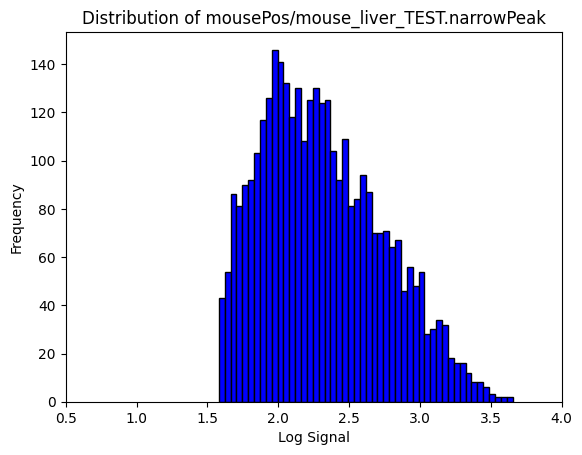

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Load the BED file into a pandas DataFrame
def plot_histogram_from_bed(file_path):
    # Load the BED file, assuming it's tab-separated and without a header
    df = pd.read_csv(file_path, sep='\t', header=None)

    # Ensure the file has at least 5 columns
    if df.shape[1] < 5:
        raise ValueError("The BED file must have at least 5 columns.")

    # Extract the 5th column (index 4 in pandas, since it starts from 0)
    column_5 = df[4]

    # Plot the histogram
    plt.hist(column_5, bins=50, color='blue', edgecolor='black')
    plt.xlim(0.5, 4)
    tit = ('/').join(file_path.split('/')[-2:])
    plt.title(f'Distribution of {tit}')
    plt.xlabel('Log Signal')
    plt.ylabel('Frequency')
    
    # Show the plot
    plt.show()

# Example usage
file_path = '/home/azstephe/regression_liver/data/sorted_log_20615/splits/mousePos/mouse_liver_TEST.narrowPeak'  # Replace with your BED file path
plot_histogram_from_bed(file_path)